# Introduction to Cross-Validation

## Introduction

You learned about train-test-split before, but also noticed that running the model with a different split for train and test can lead to significantly different results. This is one of the many reasons why you'll want to consider cross-valisation!

## Objectives

You will be able to:
- Explain the superiority of cross-validation over simple validation testing
- Understand and implement k-fold cross validation in Scikit Learn

## The problem with train-test-split

When using train-test-split, random samples of the data are created for the training and the test set. The problem with this is that the training and test MSE strongly depend on how the training and test sets were created. Let's see how this happens in practice using the auto-mpg data.

Let's copy our pre-processed auto-mpg data again

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("auto-mpg.csv") 
data['horsepower'].astype(str).astype(int)

acc = data["acceleration"]
logdisp = np.log(data["displacement"])
loghorse = np.log(data["horsepower"])
logweight= np.log(data["weight"])

scaled_acc = (acc-min(acc))/(max(acc)-min(acc))	
scaled_disp = (logdisp-np.mean(logdisp))/np.sqrt(np.var(logdisp))
scaled_horse = (loghorse-np.mean(loghorse))/(max(loghorse)-min(loghorse))
scaled_weight= (logweight-np.mean(logweight))/np.sqrt(np.var(logweight))

data_fin = pd.DataFrame([])
data_fin["acc"]= scaled_acc
data_fin["disp"]= scaled_disp
data_fin["horse"] = scaled_horse
data_fin["weight"] = scaled_weight
cyl_dummies = pd.get_dummies(data["cylinders"], prefix="cyl")
yr_dummies = pd.get_dummies(data["model year"], prefix="yr")
orig_dummies = pd.get_dummies(data["origin"], prefix="orig")
mpg = data["mpg"]
data_fin = pd.concat([mpg, data_fin, cyl_dummies, yr_dummies, orig_dummies], axis=1)

In [2]:
data = pd.concat([mpg, scaled_acc, scaled_weight, orig_dummies], axis= 1)
y = data[["mpg"]]
X = data.drop(["mpg"], axis=1)

The code below repeats a train-test-split creation 20 times, using a test_size of 0.33. So what happens is, each time a new (random) train-test-split is created. See how training and testing MSEs swing around by just taking another sample!

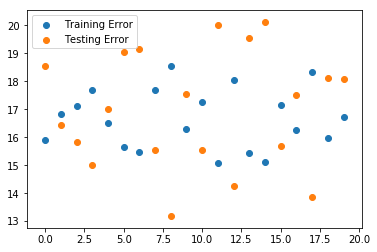

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

linreg = LinearRegression()

num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called **K-Fold Cross Validation**.

## K-Fold Cross Validation

K-Fold Cross Validation expands on the idea of training and testing splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the testing set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

<img src='cross-val-graphic.png'>

You can easily do this in scikit-learn using `cross_val_score`. If you want the mean squared error as an output, you need to specify `scoring` and pass "neg_mean_squared_error". Note that this negates your mean squared error, so larger means better!

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

There are many ways to perform Cross-validations, and we strongly recommend you have a look at the [Cross-validation documentation in Scikit-Learn](http://scikit-learn.org/stable/modules/cross_validation.html)

## Summary 

Great! Now let's put this into practice on our Boston Housing Data!